** Python Lab 3**

Welcome back to the python labs! These labs are designed to give you more exposure and experience using python and various packages for data analysis work.

In this lab we will:
- Read in the output file 'Lab_01_output.csv' from lab 1
- Transform the data to a timeseries again
- Create a model of that timeseries
- Use the model to create a forecast of the timeseries
- Graph and analyze the new forecast
- Create a second model then forecast and graph
- Save the resulting data to a file for future analysis

A common business analytics task is forecasting and in this lab we will use a package called Prophet to help us model and forecast some timeseries web data. There are thousands of packages built for python to tackle a wide range of applications and Prophet is just one of many. 

Accurate and fast. Fully automatic. Tunable forecasts. Available in R or Python.
https://facebookincubator.github.io/prophet/

Prophet is quick and seeks to provide a simple to use model that's also sophisticated enough to provide useful results via several tuneable parameters even without deep forecasting knowledge. To get started with Prophet, you’ll first need to install it. The major dependency that Prophet has is PyStan which handles the math crunching. Installation instructions for PyStan and Prophet are below but for most people they will be able to install PyStan and then Prophet by opening a terminal and typing the following commands and hitting enter:

    pip install pystan
    pip install fbprophet

Installation instructions can be found here:
- http://pystan.readthedocs.io/en/latest/installation_beginner.html
- https://facebookincubator.github.io/prophet/docs/installation.html

Using Prophet is extremely straightforward. You import it, load some data into a pandas dataframe, set the data up into the proper format and then start modeling and forecasting. Let's start by importing some packages and using basically the same code as the last lab to start off but now with the addition of importing pystan and prophet from fbprophet as so.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Prophet to forecast
import pystan
from fbprophet import Prophet
# show plots in the notebook
%matplotlib inline
#default notebook setup
MAX_ROWS = 10
pd.set_option('display.max_rows', MAX_ROWS)
pd.set_option('display.max_columns', 200)
pd.options.display.float_format = '{:3f}'.format # suppresses scientific notation in pandas
# Seaborn styling
sns.set(context='notebook', style='white')

#### Read in the output file 'Lab_01_output.csv' from lab 1 ####

And now let's read in the output file 'Lab_01_output.csv' from the previous lab 1

In [2]:
data = pd.read_csv('../Lab_1/Lab_01_output.csv', encoding="latin1", index_col=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4999 entries, 0 to 4998
Data columns (total 10 columns):
referrer           3740 non-null object
timestamp          4999 non-null object
title              4996 non-null object
url                4999 non-null object
user_agent         4999 non-null object
user_id            4999 non-null object
referrer_domain    3738 non-null object
website_section    3703 non-null object
platform           4999 non-null object
pageviews          4999 non-null int64
dtypes: int64(1), object(9)
memory usage: 429.6+ KB


Now we need to resample this website log data down into a timeseries so we can model and then forecast the data. First let's set the timestamp column to datetime format and then as the index of the table since we are creating a timeseries.

In [3]:
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [4]:
data.index = data['timestamp']

Confirm the change..

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4999 entries, 2016-02-05 00:48:23 to 2015-11-17 16:38:25
Data columns (total 10 columns):
referrer           3740 non-null object
timestamp          4999 non-null datetime64[ns]
title              4996 non-null object
url                4999 non-null object
user_agent         4999 non-null object
user_id            4999 non-null object
referrer_domain    3738 non-null object
website_section    3703 non-null object
platform           4999 non-null object
pageviews          4999 non-null int64
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 429.6+ KB


#### Transform the data to a timeseries ####

Now let's take the dataset and resample the timestamp index to 'days' and sum up the number of pageviews per day, then plot

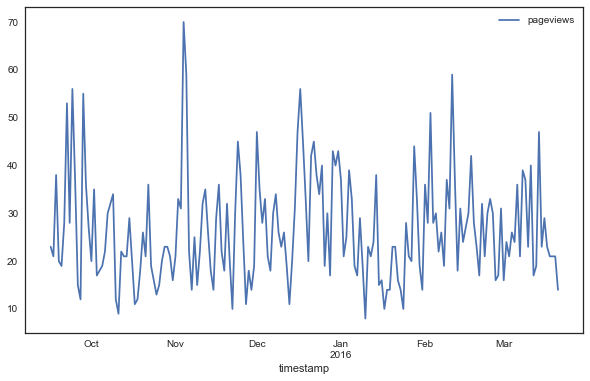

In [6]:
data.resample('D').sum().plot(figsize=(10,6)); 
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html

This is the data that we need and will be forecasting so let's copy this back to 'data' dropping the rest of the data points we don't need.

In [7]:
data = data.resample('D').sum()
data.head()

,pageviews
timestamp,
2015-09-16,23
2015-09-17,21
2015-09-18,38
2015-09-19,20
2015-09-20,19


Get some meta with .info()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188 entries, 2015-09-16 to 2016-03-21
Freq: D
Data columns (total 1 columns):
pageviews    188 non-null int64
dtypes: int64(1)
memory usage: 2.9 KB


And let's create a holdout set of dates to create a period to forecast for and test our model and predicitons with. For this we'll simply cut the last 46 days from the data and store them in a 'holdout' variable.

In [9]:
train = data[:142].copy()
holdout = data[-46:].copy()
print('holdout count:', len(holdout))
print('train count:', len(train))
print('total:', (len(holdout)+len(train)))

holdout count: 46
train count: 142
total: 188


In [10]:
train.tail()

,pageviews
timestamp,
2016-01-31,14
2016-02-01,36
2016-02-02,28
2016-02-03,51
2016-02-04,28


In [11]:
holdout

,pageviews
timestamp,
2016-02-05,30
2016-02-06,22
2016-02-07,26
2016-02-08,19
2016-02-09,37
...,...
2016-03-17,23
2016-03-18,21
2016-03-19,21


Now let's call .info() on the train dataframe and quickly inspect by .plot()

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142 entries, 2015-09-16 to 2016-02-04
Freq: D
Data columns (total 1 columns):
pageviews    142 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


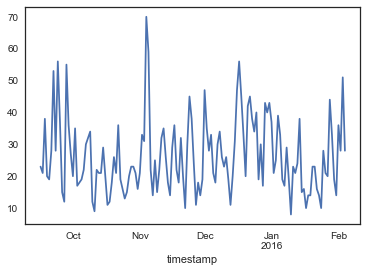

In [13]:
train['pageviews'].plot();

Now there seems to be a peak around November 2015.  Let's use a boolean in 'train.loc[ ]' to filter down to those days where pageviews were greater than 60

In [14]:
train.loc[(train['pageviews'] > 60)]

,pageviews
timestamp,
2015-11-04,70


We see this high point occurred on the 4th of November 2015. At this point, we could use numpy's NaN and set it to NaN like so

            train.loc[(train['pageviews']> 60), 'pageviews'] = np.nan 
            
But let's leave it in as it seems to be a part of a reoccurring trend in the data. We are though going to apply a log transformation to train['pageviews']. We can do this by using numpy's log() on the dataframe column 'pageviews'

            np.log(train['pageviews'])

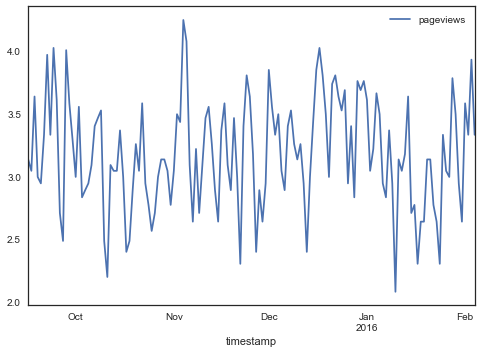

In [15]:
# Transform pageviews to a log value
train['pageviews'] = np.log(train['pageviews'])
train.plot();

The data set is almost ready for prophet and to model. The final step is to rename the columns to 'ds' and 'y' in order to comply with the prophet API. But first we need to reset the index using .reset_index(inplace=True) as this will drop the time from the index and into a column so we can then rename 'ds' per prophet's naming conventions.

In [16]:
train.reset_index(inplace=True) # reset the column in place
train.columns = ["ds", "y"] # assign the new names to the .columns attribute of the dataframe
train.head()

,ds,y
0,2015-09-16,3.135494
1,2015-09-17,3.044522
2,2015-09-18,3.637586
3,2015-09-19,2.995732
4,2015-09-20,2.944439


#### Create a model of that timeseries ####

Now the data is cleaned, transformed, and labeled correctly so let's load it into prophet and make a predicition. The flow of this process is typical and similar to other python modeling packages like scikit-learn. http://scikit-learn.org

First we're going to fit or model the data and then predict the future time series using that model. We'll then plot the results as Prophet supports plotting using plot and plot_components.

Let's create the first model by assigning Prophet() and call .fit() on our dataframe

In [17]:
# Create the first model (m1) and fit the data to our dataframe
m1 = Prophet()
m1.fit(train)     # 'train' is the timeseries data you want to model

#### Use the model to create a forecast of the timeseries ####

We then use the helper method make_future_dataframe on m1 to tell prophet how far we want to use model m1 to predict into the future. We are forecasting for the next 46 days so our frequency will be 'D' for days and periods=46.

    m1.make_future_dataframe(periods=46, freq='D', include_history=True))
    
    

In [18]:
# This takes the model we built and creates the necessary dataframe based on the period we are forecasting
future1 = m1.make_future_dataframe(periods=46, freq='D', include_history=True)

Then make the forecast with .predict() on m1 like so
       
    m1.predict(future1)

In [19]:
forecast1 = m1.predict(future1)

forecast1 is just a pandas dataframe with several columns of data populated by .predict(). The predicted value is called *yhat* and the range of the prediction is defined by *yhat_lower* and *yhat_upper* . We can use .tail() to review the last 5 predicted values

In [20]:
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
183,2016-03-17,3.878858,3.525247,4.232949
184,2016-03-18,3.755183,3.379293,4.087372
185,2016-03-19,3.311957,2.948849,3.670671
186,2016-03-20,3.115099,2.801015,3.497952
187,2016-03-21,3.618879,3.235691,3.973234


To convert the log values back to the numerical values representing pageviews use np.exp

In [21]:
np.exp(forecast1[['yhat', 'yhat_lower', 'yhat_upper']].tail())

,yhat,yhat_lower,yhat_upper
183,48.368925,33.962154,68.920152
184,42.742021,29.350010,59.583119
185,27.438766,19.083977,39.278244
186,22.535672,16.461351,33.047715
187,37.295727,25.423945,53.156169


#### Graph and analyze the new forecast ####

And now we can plot the data and forecast. As mentioned above all of the projections are still based on the log scale so we need to convert them back

In [22]:
forecast1[['yhat', 'yhat_lower', 'yhat_upper']].tail()

,yhat,yhat_lower,yhat_upper
183,3.878858,3.525247,4.232949
184,3.755183,3.379293,4.087372
185,3.311957,2.948849,3.670671
186,3.115099,2.801015,3.497952
187,3.618879,3.235691,3.973234


But instead of converting them back into the same columns we are going to create new 'forecast', forecast_lower' and 'forecast_upper' columns for the converted values. We will want to associate 'forecast1' to 'forecast' dataframe variable to streamline the process and inspect the end of the dataset with .tail() like so

In [23]:
forecast1['forecast'] = np.exp(forecast1['yhat']).round()
forecast1['forecast_lower'] = np.exp(forecast1['yhat_lower']).round()
forecast1['forecast_upper'] = np.exp(forecast1['yhat_upper']).round()

forecast = forecast1

forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat,forecast,forecast_lower,forecast_upper
183,2016-03-17,1.297872,3.283040,0.595817,0.595817,3.283040,3.283040,3.525247,4.232949,0.240882,0.240882,0.240882,0.354935,0.354935,0.354935,0.595817,3.878858,48.000000,34.000000,69.000000
184,2016-03-18,1.304965,3.284253,0.470929,0.470929,3.284253,3.284253,3.379293,4.087372,0.118038,0.118038,0.118038,0.352891,0.352891,0.352891,0.470929,3.755183,43.000000,29.000000,60.000000
185,2016-03-19,1.312057,3.285467,0.026490,0.026490,3.285467,3.285467,2.948849,3.670671,-0.315802,-0.315802,-0.315802,0.342292,0.342292,0.342292,0.026490,3.311957,27.000000,19.000000,39.000000
186,2016-03-20,1.319149,3.286680,-0.171581,-0.171581,3.286680,3.286680,2.801015,3.497952,-0.495117,-0.495117,-0.495117,0.323536,0.323536,0.323536,-0.171581,3.115099,23.000000,16.000000,33.000000
187,2016-03-21,1.326241,3.287893,0.330985,0.330985,3.287893,3.287893,3.235691,3.973234,0.033748,0.033748,0.033748,0.297237,0.297237,0.297237,0.330985,3.618879,37.000000,25.000000,53.000000


We can also see the various components and trends the model 'sees' in the data but note the data points in these plots are still logs since we didn't convert them in place in their respective columns but instead to new columns these plotting functions aren't currently reading. Let's try this out with the .plot() function first and then plot_components() to plot the forecast and the various components of the forecast

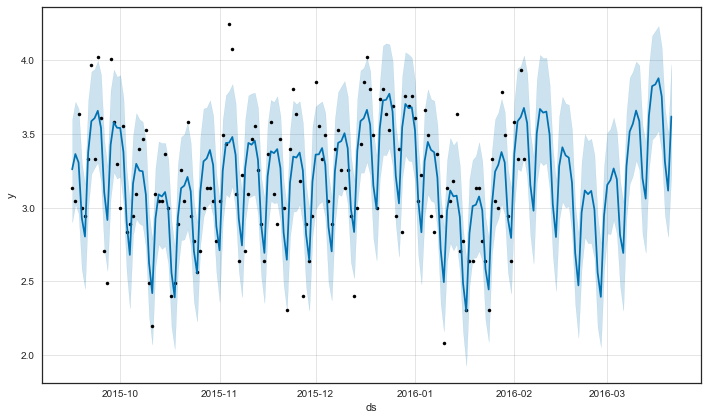

In [24]:
# 'm1' is our model and we want to .plot() our forecast dataframe with the yhat columns
m1.plot(forecast);

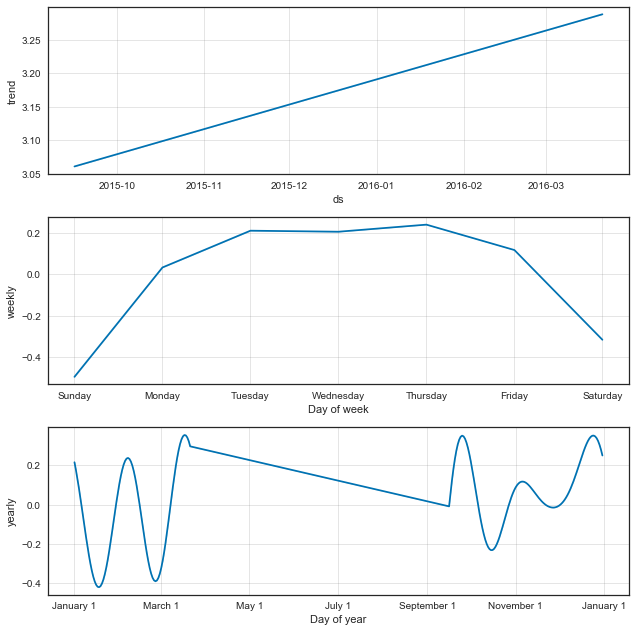

In [25]:
# 'm1' is our model and we want to .plot_components() to see the models components
m1.plot_components(forecast);

So now let's compare our forecasted 46 day period from our first model to the holdout data set of 46 days from 2016-02-05 to 2016-03-21. First let's inspect it via .head()

In [26]:
holdout.head()

,pageviews
timestamp,
2016-02-05,30
2016-02-06,22
2016-02-07,26
2016-02-08,19
2016-02-09,37


You can see that 'holdout' dataframe has 'timestamp' set as the index. In other words, it has a datetime index that we will want to reset so 'timestamp' is treated as a simple column and not the index of the timeseries. We can do this by calling .reset_index(inplace=True) . Let's also take this opportunity to rename the columns to 'ds' and 'actual' since this is our actual numbers and 'ds' is what our date column is titled

In [27]:
holdout.reset_index(inplace=True)
holdout.columns = ['ds', 'actual']
holdout.tail()

,ds,actual
41,2016-03-17,23
42,2016-03-18,21
43,2016-03-19,21
44,2016-03-20,21
45,2016-03-21,14


Now let's merge the actuals in the holdout dataframe with our forecasted dataframe on the shared date column 'ds' so that we have the actuals and forecast in a single dataframe called 'df'

In [28]:
df = pd.merge(holdout, forecast, on='ds')
df.head(3)

,ds,actual,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat,forecast,forecast_lower,forecast_upper
0,2016-02-05,30,1.007092,3.233294,0.341498,0.341498,3.233294,3.233294,3.206192,3.911122,0.118038,0.118038,0.118038,0.223460,0.223460,0.223460,0.341498,3.574792,36.000000,25.000000,50.000000
1,2016-02-06,22,1.014184,3.234507,-0.080927,-0.080927,3.234507,3.234507,2.805853,3.503231,-0.315802,-0.315802,-0.315802,0.234875,0.234875,0.234875,-0.080927,3.153580,23.000000,17.000000,33.000000
2,2016-02-07,26,1.021277,3.235720,-0.256970,-0.256970,3.235720,3.235720,2.619774,3.341599,-0.495117,-0.495117,-0.495117,0.238147,0.238147,0.238147,-0.256970,2.978750,20.000000,14.000000,28.000000


Inspect the end of the dataset as well..

In [29]:
df.tail(3)

,ds,actual,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat,forecast,forecast_lower,forecast_upper
43,2016-03-19,21,1.312057,3.285467,0.026490,0.026490,3.285467,3.285467,2.948849,3.670671,-0.315802,-0.315802,-0.315802,0.342292,0.342292,0.342292,0.026490,3.311957,27.000000,19.000000,39.000000
44,2016-03-20,21,1.319149,3.286680,-0.171581,-0.171581,3.286680,3.286680,2.801015,3.497952,-0.495117,-0.495117,-0.495117,0.323536,0.323536,0.323536,-0.171581,3.115099,23.000000,16.000000,33.000000
45,2016-03-21,14,1.326241,3.287893,0.330985,0.330985,3.287893,3.287893,3.235691,3.973234,0.033748,0.033748,0.033748,0.297237,0.297237,0.297237,0.330985,3.618879,37.000000,25.000000,53.000000


Now let's create a 'delta' column and input the difference between the actual and forecasted. Then let's use .describe() on that new df['delta'] column to get basic stats on the difference between the actuals and forecasted.

In [30]:
df['delta'] = df['actual'] - df['forecast']
df['delta'].describe()

count    46.000000
mean     -0.260870
std      11.060309
min     -25.000000
25%      -6.000000
50%       0.500000
75%       6.750000
max      21.000000
Name: delta, dtype: float64

Next we are going to plot and compare our forecast from our first model with the actual numbers. First, we need to convert our df['ds'] column to just dates so .plot() doesn't throw errors in the graphing process. You can do that like so.

In [31]:
# Need to convert to just a date in order to keep plot from throwing errors
df['ds'] = df['ds'].dt.date

Now the chuck of code below will create a large graph of the forecasted values and the actuals. It'll also have a shaded region which represents the upper and lower bounds of the predicted forecast. I've commented the code heavily so you can figure out what is going on. Copy and run the chuck of code below..

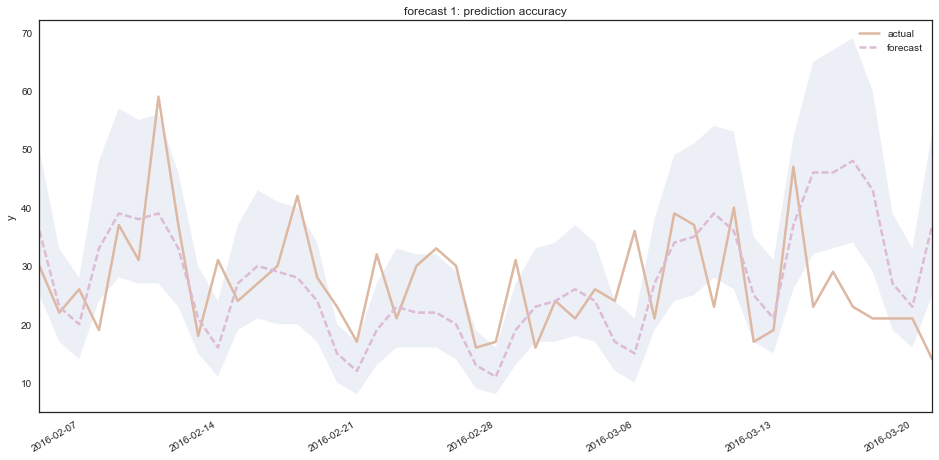

In [32]:
# ,subplots() is a utility wrapper that conveniently creates a figure and a sublot for you to customize to your liking
fig1, ax = plt.subplots(figsize=(16, 8)) # https://matplotlib.org/examples/pylab_examples/subplots_demo.html

# plotting the graph with pandas.DataFrame.plot setting the parameters 
# Read more: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

df.plot(kind='line', # type of plot such as line, bar, barh, hist, box, kde, density, area, pie, scatter, hexbin
        x='ds',     # label or position
        y=['actual', 'forecast'],     # label or position
        ax=ax,     # matplotlib axes object...from above, default None
        style=['-','--'],     # list or dict matplotlib line style per column..y1 is solid, y2 is dotted line
        color=['#ddb8a3','#debbd4'],    # y1,y2 colors using appealing hex codes
        linewidth=2.5)     # line width

# Next line of code creates the shaded region using the upper and lower bounds of the forecast as the boundries
# Read more: https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.fill_between.html
ax.fill_between(df['ds'].values, df['forecast_lower'], df['forecast_upper'], alpha=0.1)

# Set some additional properties and parameters to our liking such as title and angle of x-axis
ax.set(title='forecast 1: prediction accuracy', xlabel='', ylabel='y')
# Read more: https://matplotlib.org/faq/howto_faq.html

# x-axis setting
fig1.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
# Read more: https://matplotlib.org/api/figure_api.html#matplotlib.figure.Figure.autofmt_xdate

#### Create a second model then forecast and graph ####

Great work! Now we are going to make a second model based on the training data and create a new forecast but this time we are going to use more of the parameters available in prophet to try and generate a better forecast. One of them is the ability to model holidays or other recurring events. If you have holidays or other recurring events that you’d like to model, you must create a dataframe for them so let's read in the file 'holidays.xlsx' and inspect the head()

In [33]:
# Read in holiday excel file and inspect
holidays = pd.read_excel('holidays.xlsx')
holidays.head()

,ds,holiday
0,2015-01-01,NYE
1,2015-01-19,MLK
2,2015-02-16,Washington
3,2015-04-03,Good Friday
4,2015-05-25,Memorial


In [34]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
ds         42 non-null datetime64[ns]
holiday    42 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 752.0+ bytes


Here we have two columns. One date type named 'ds' and the other colum a string titled 'holiday' and a row for each occurrence of the holiday. It must include all occurrences of the holiday, both in the past (back as far as the historical data goes that you want to model) and in the future (out as far as the forecast is being made). You can also include columns 'lower_window' and 'upper_window' which extend the holiday out to [lower_window, upper_window] days around the date. More information on these controls can be found at the link below. https://facebookincubator.github.io/prophet/docs/seasonality_and_holiday_effects.html

Ok now let's create a second model using more of the features and parameters in prophet. I'll comment the chuck of code below so you can start to see and figure out what the code is doing but I encourage you to review prophet's documentation at the link below to learn more about the parameters available. Now copy and run the chuck of code in the next cell. See here for more information on prophet's settings: https://facebookincubator.github.io/prophet/docs/quick_start.html#python-api

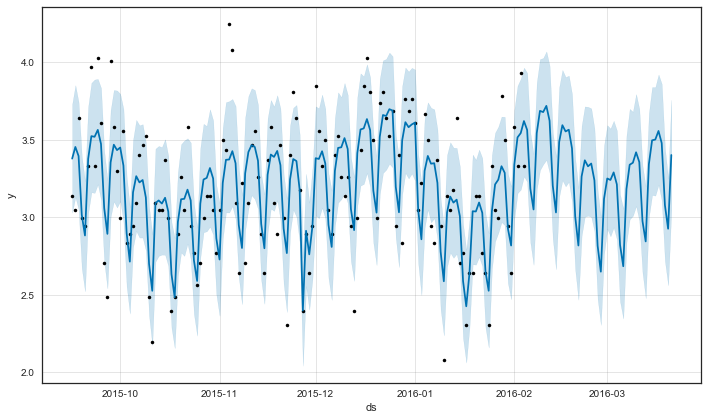

In [35]:
# Create the second model (m2) and fit the data to our train dataframe setting a slew of model parameters in the process
m2 = Prophet(growth='linear', # String 'linear' or 'logistic' to specify a linear or logistic trend model
             changepoint_prior_scale=1.25,  # If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the input argument changepoint_prior_scale.
             yearly_seasonality=True, # Boolean, fit yearly seasonality
             weekly_seasonality=True, # Boolean, fit weekly seasonality
             seasonality_prior_scale=0.02,
             mcmc_samples=0, # Integer, if great than 0, will do full Bayesian inference with the specified number of MCMC samples. If 0, will do MAP estimation.
             holidays=holidays, # To use the holidays in the model, pass the dataframe to the model via the 'holidays' keyword
             holidays_prior_scale=8, # If you find that the holidays are overfitting, you can adjust their prior scale to smooth them using the parameter holidays_prior_scale.
            ).fit(train)

# This takes the m2 model we built and creates the necessary dataframe based on the 46 day period we are forecasting for
future2 = m2.make_future_dataframe(periods=46, freq='D')

# Makes the prediciton
forecast2 = m2.predict(future2)

# Plots new forecast based on m2 model that includes holidays
m2.plot(forecast2); 

Above is the new forecast produced by our second model. We can also inspect the components of the model to see what the model is picking up on. We can do this by calling m2.plot_components(forecast2); like so

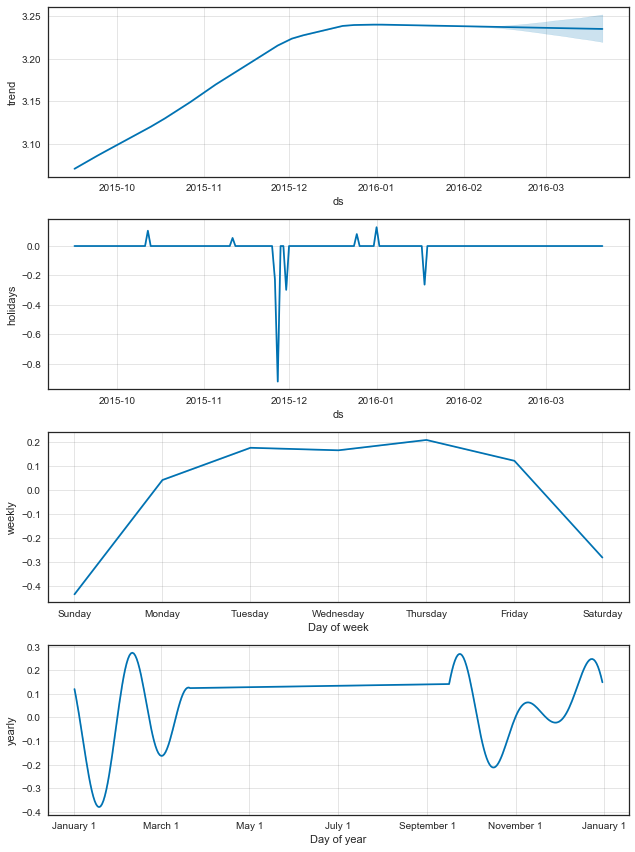

In [36]:
m2.plot_components(forecast2);

Here we can see how the new m2 model is interpreting the overall trend along with the holidays, weekly, and yearly trends as well and by calling .tail() on forecast2 we can see we have new yhats or predicted values

In [37]:
forecast2[['yhat', 'yhat_lower', 'yhat_upper']].tail()

,yhat,yhat_lower,yhat_upper
183,3.557126,3.210092,3.921132
184,3.478611,3.108543,3.860579
185,3.078623,2.716538,3.445917
186,2.925831,2.561257,3.249605
187,3.401879,3.046617,3.757961


Now as before let us go through the process of converting the predicted values from log-transformed values back into pageviews and label them 'forecast', forecast_lower' and 'forecast_upper' colummns. We'll then associate 'forecast2' to 'forecast' and inspect the end of the dataset with .tail()

In [38]:
forecast2['forecast'] = np.exp(forecast2['yhat']).round()
forecast2['forecast_lower'] = np.exp(forecast2['yhat_lower']).round()
forecast2['forecast_upper'] = np.exp(forecast2['yhat_upper']).round()

forecast = forecast2

forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,Black Friday,Black Friday_lower,Black Friday_upper,Christmas,Christmas_lower,Christmas_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Cyber Monday,Cyber Monday_lower,Cyber Monday_upper,Good Friday,Good Friday_lower,Good Friday_upper,Green Monday,Green Monday_lower,Green Monday_upper,Independence,Independence_lower,Independence_upper,Labour Day,Labour Day_lower,Labour Day_upper,MLK,MLK_lower,MLK_upper,Memorial,Memorial_lower,Memorial_upper,NYE,NYE_lower,NYE_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Washington,Washington_lower,Washington_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat,forecast,forecast_lower,forecast_upper
183,2016-03-17,1.297872,3.235436,0.321689,0.321689,3.222141,3.250313,3.210092,3.921132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.209877,0.209877,0.209877,0.111813,0.111813,0.111813,0.321689,3.557126,35.000000,25.000000,50.000000
184,2016-03-18,1.304965,3.235371,0.243240,0.243240,3.221521,3.250870,3.108543,3.860579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122656,0.122656,0.122656,0.120583,0.120583,0.120583,0.243240,3.478611,32.000000,22.000000,47.000000
185,2016-03-19,1.312057,3.235307,-0.156684,-0.156684,3.221011,3.251248,2.716538,3.445917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.282320,-0.282320,-0.282320,0.125636,0.125636,0.125636,-0.156684,3.078623,22.000000,15.000000,31.000000
186,2016-03-20,1.319149,3.235242,-0.309411,-0.309411,3.220509,3.251804,2.561257,3.249605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.436307,-0.436307,-0.436307,0.126896,0.126896,0.126896,-0.309411,2.925831,19.000000,13.000000,26.000000
187,2016-03-21,1.326241,3.235177,0.166703,0.166703,3.219794,3.252275,3.046617,3.757961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042302,0.042302,0.042302,0.124400,0.124400,0.124400,0.166703,3.401879,30.000000,21.000000,43.000000


Merge the new forecast with the holdout data into a single dataframe named 'df' as before

In [39]:
df = pd.merge(holdout, forecast, on='ds')
df.tail()

,ds,actual,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,Black Friday,Black Friday_lower,Black Friday_upper,Christmas,Christmas_lower,Christmas_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Cyber Monday,Cyber Monday_lower,Cyber Monday_upper,Good Friday,Good Friday_lower,Good Friday_upper,Green Monday,Green Monday_lower,Green Monday_upper,Independence,Independence_lower,Independence_upper,Labour Day,Labour Day_lower,Labour Day_upper,MLK,MLK_lower,MLK_upper,Memorial,Memorial_lower,Memorial_upper,NYE,NYE_lower,NYE_upper,Thanksgiving,Thanksgiving_lower,Thanksgiving_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Washington,Washington_lower,Washington_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,seasonal,yhat,forecast,forecast_lower,forecast_upper
41,2016-03-17,23,1.297872,3.235436,0.321689,0.321689,3.222141,3.250313,3.210092,3.921132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.209877,0.209877,0.209877,0.111813,0.111813,0.111813,0.321689,3.557126,35.000000,25.000000,50.000000
42,2016-03-18,21,1.304965,3.235371,0.243240,0.243240,3.221521,3.250870,3.108543,3.860579,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122656,0.122656,0.122656,0.120583,0.120583,0.120583,0.243240,3.478611,32.000000,22.000000,47.000000
43,2016-03-19,21,1.312057,3.235307,-0.156684,-0.156684,3.221011,3.251248,2.716538,3.445917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.282320,-0.282320,-0.282320,0.125636,0.125636,0.125636,-0.156684,3.078623,22.000000,15.000000,31.000000
44,2016-03-20,21,1.319149,3.235242,-0.309411,-0.309411,3.220509,3.251804,2.561257,3.249605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.436307,-0.436307,-0.436307,0.126896,0.126896,0.126896,-0.309411,2.925831,19.000000,13.000000,26.000000
45,2016-03-21,14,1.326241,3.235177,0.166703,0.166703,3.219794,3.252275,3.046617,3.757961,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042302,0.042302,0.042302,0.124400,0.124400,0.124400,0.166703,3.401879,30.000000,21.000000,43.000000


Now create the 'delta' column and input the difference between the actual and forecasted. Then use .describe() on df['delta'] column to get basic stats on the difference between the actuals and new forecast.

In [40]:
df['delta'] = df['actual'] - df['forecast']
df['delta'].describe()

count    46.000000
mean     -0.195652
std       8.665691
min     -16.000000
25%      -6.750000
50%      -1.000000
75%       5.000000
max      21.000000
Name: delta, dtype: float64

Next convert our df['ds'] column to just dates so .plot() doesn't throw errors in the graphing process and plot and compare our new forecast to the actual numbers

In [41]:
# Need to convert to just a date in order to keep plot from throwing errors
df['ds'] = df['ds'].dt.date

Now graph the predicted vs actuals from the second forecast by referencing the dataframe and columns as before

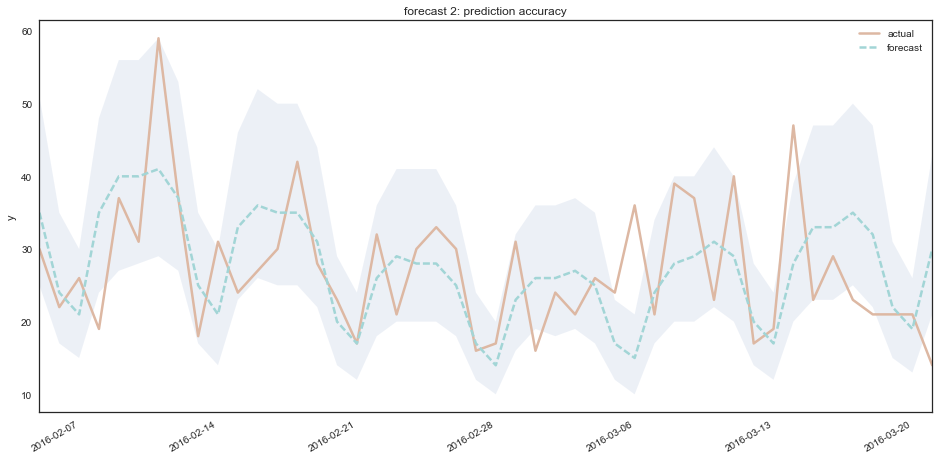

In [42]:
fig2, ax = plt.subplots(figsize=(16, 8))
df.plot(kind='line', x='ds', y=['actual', 'forecast'], ax=ax, style=['-','--'], color=['#ddb8a3','#a2d5d6'], linewidth=2.5)
ax.fill_between(df['ds'].values, df['forecast_lower'], df['forecast_upper'], alpha=0.1)
ax.set(title='forecast 2: prediction accuracy', xlabel='', ylabel='y')
fig2.autofmt_xdate(bottom=0.2, rotation=30, ha='right')

Recall fig1 of our first prediction(forecast1) from our first model to compare to our second prediction(forecast2) in fig2 from our second model.

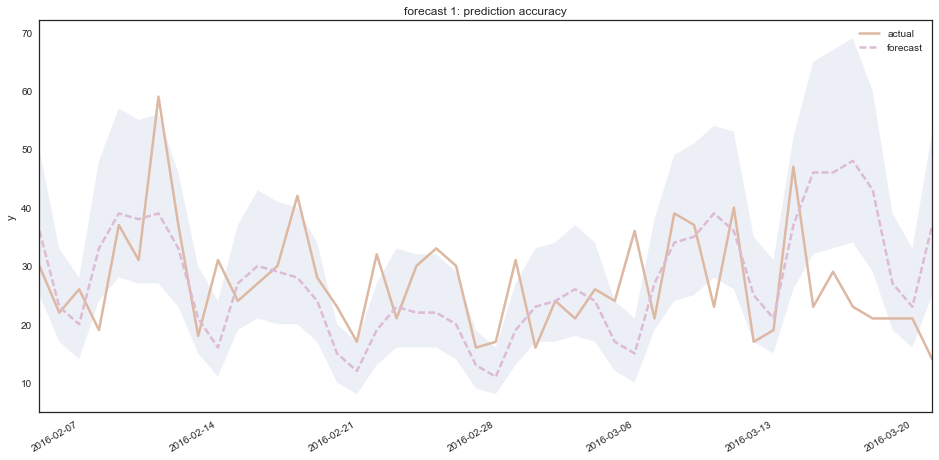

In [43]:
fig1

#### Save the resulting data to a file for future analysis ####

Now pull out the columns we want to save and tie them to 'output' and then we can save 'output' to csv like so.

In [44]:
output = df[['ds', 'actual', 'forecast', 'forecast_lower', 'forecast_upper']]
output

,ds,actual,forecast,forecast_lower,forecast_upper
0,2016-02-05,30,35.000000,25.000000,51.000000
1,2016-02-06,22,24.000000,17.000000,35.000000
2,2016-02-07,26,21.000000,15.000000,30.000000
3,2016-02-08,19,35.000000,24.000000,48.000000
4,2016-02-09,37,40.000000,27.000000,56.000000
...,...,...,...,...,...
41,2016-03-17,23,35.000000,25.000000,50.000000
42,2016-03-18,21,32.000000,22.000000,47.000000
43,2016-03-19,21,22.000000,15.000000,31.000000
44,2016-03-20,21,19.000000,13.000000,26.000000


In [45]:
output.to_csv('Lab_03_output.csv', )

Congratulations! You have now successfully built two different timeseries models and made a forecast with each one that you then compared to the actual number of daily pageviews to see how your predictions did. There are tons of packages like prophet that are designed to help you with your data analysis needs. I encourage you to explore more. You are also now done with lab 3 and python 101 training. Great job!